# Join data for Shots

* Group json files by repetitions
* Extract error and runs data
* Average this data
* Save in a new json file

In [1]:
from os import walk
import json
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.metrics import mean_squared_error


optimizers = ["gradient_descent", "spsa", "adam", "demon_adam"]
train_types= ['vqe_random', 'vqe_previous','meta', 'opt_meta']

with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)  

fci_energies = fci_h2["energies"]


f = []
for (dirpath, dirnames, filenames) in walk('./'):
    f.extend(filenames)
    break

print(len(f))

12


In [2]:
# Ordered by pairs - fd,ps
main_groups = ["simplified2design_3layers_fd", "simplified2design_3layers_ps", "simplified2design_4layers_fd", "simplified2design_4layers_ps","meta_singles_doubles_fd", "meta_singles_doubles_ps", "meta_doubles_fd", "meta_doubles_ps","kupccgsd_1layers_fd", "kupccgsd_1layers_ps"]

In [3]:
condensed_data = []

for group_count,file_name_base in enumerate(main_groups):

    with open(f'./{file_name_base}.json', 'r') as reader:
        # Read & print the entire file
        data = reader.read()
        data_entry = json.loads(data)
    
    group_dict = {i:{"errors":[0.0 for _ in train_types], "runs":[ 0 for _ in train_types]} for i in optimizers}
    for opt in optimizers:
        for count, result_type in enumerate(train_types):
            if result_type == 'meta':
                group_dict[opt]["runs"][count] += data_entry['results'][opt][result_type]['runs']
                group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, data_entry['results'][opt][result_type]["energies_after_meta"], squared=False)*1000

            else:
                group_dict[opt]["runs"][count] += np.sum(data_entry['results'][opt][result_type]['runs_per_step'])
                group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, [energy[-1] for energy in data_entry['results'][opt][result_type]["energies"]], squared=False)*1000                  

    condensed_data.append(group_dict)


In [4]:
plot_data = []
for i in range(int(len(main_groups)/2)):
    for count,result_type in enumerate(train_types):
        row=[]
        for opt in optimizers:
            row.append(condensed_data[2*i][opt]["errors"][count])
            row.append(condensed_data[2*i+1][opt]["errors"][count])
        plot_data.append(row)


In [5]:
import pandas as pd


arrays = []
for i in range(int(len(main_groups)/2)):
    for result_type in train_types:
        arrays.append((main_groups[2*i][0:-3].replace('_', '-'), result_type))

In [6]:
columns = [('Gradient','fd'),('Gradient','ps'),('SPSA','fd'),('SPSA','ps'),('ADAM','fd'),('ADAM','ps'),('DEMON ADAM','fd'),('DEMON ADAM','ps')]

In [7]:
df = pd.DataFrame(plot_data, index=arrays, columns = columns)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index = pd.MultiIndex.from_tuples(df.index)
pd.options.display.float_format = '{:22.2}'.format
df

Gradient  \
                                                           fd   
simplified2design-3layers vqe_random                  1.1e+02   
                          vqe_previous                4.2e+01   
                          meta                        1.2e+02   
                          opt_meta                    1.1e+01   
simplified2design-4layers vqe_random                  5.1e+01   
                          vqe_previous                    2.7   
                          meta                        2.5e+02   
                          opt_meta                    3.5e+01   
meta-singles-doubles      vqe_random                      1.8   
                          vqe_previous                   0.12   
                          meta                          3e+01   
                          opt_meta                       0.16   
meta-doubles              vqe_random                     0.12   
                          vqe_previous                   0.12   
                          meta                        6.8e+01   
                          opt_meta                       0.11   
kupccgsd-1layers          vqe_random                      1.5   
                          vqe_previous                  0.056   
                          meta                          2e+01   
                          opt_meta                      0.055   

                                                               \
                                                           ps   
simplified2design-3layers vqe_random                  1.1e+02   
                          vqe_previous                4.2e+01   
                          meta                        1.2e+02   
                          opt_meta                    1.1e+01   
simplified2design-4layers vqe_random                  5.1e+01   
                          vqe_previous                    2.7   
                          meta                        2.5e+02   
                          opt_meta                    3.5e+01   
meta-singles-doubles      vqe_random                      1.8   
                          vqe_previous                   0.12   
                          meta                          3e+01   
                          opt_meta                       0.16   
meta-doubles              vqe_random                     0.12   
                          vqe_previous                   0.12   
                          meta                        6.8e+01   
                          opt_meta                       0.11   
kupccgsd-1layers          vqe_random                      1.3   
                          vqe_previous                  0.056   
                          meta                          2e+01   
                          opt_meta                      0.055   

                                                         SPSA  \
                                                           fd   
simplified2design-3layers vqe_random                  5.2e+02   
                          vqe_previous                2.7e+02   
                          meta                        8.6e+02   
                          opt_meta                    5.8e+01   
simplified2design-4layers vqe_random                  5.4e+02   
                          vqe_previous                2.3e+02   
                          meta                        6.3e+02   
                          opt_meta                    5.2e+01   
meta-singles-doubles      vqe_random                  5.7e+01   
                          vqe_previous                    1.6   
                          meta                        1.5e+02   
                          opt_meta                        2.1   
meta-doubles              vqe_random                  1.4e+01   
                          vqe_previous                   0.73   
                          meta                        1.2e+02   
                          opt_meta                       0.93   
kupccgsd-1layers     

In [8]:
# print(df.to_latex(float_format="{:.3e}".format))

In [9]:
## Simplified: (WIRES + LAYERS*(WIRES-1)*2)
## Single Double Excitations: 1 per excitation
## kupccgsd: 6*LAYERS

## For fd: (Nvars*4)+1
overheads_fd = [89,113,13,5,25]

## For ps - simplified: (Nvars*2)*4
## For ps - excitations, kupccgsd: (Nvars*4)*4
overheads_ps = [176,224,48,16,96]

index_per_runs_plot_fd = [0,2,4,6,8]
index_per_runs_plot_ps = [1,3,5,7,9]

# overheads_fd = [13,5,25]
# overheads_ps = [48,16,96]




# index_per_runs_plot_fd = [0,2,4]
# index_per_runs_plot_ps = [1,3,5]

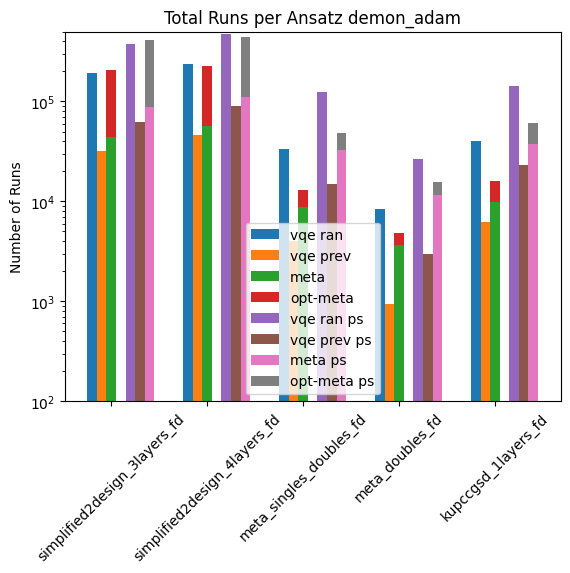

In [10]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_ran_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]
vqe_prev_data = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_fd)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][3]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]

vqe_ran_data_ps = [condensed_data[idx][opt_runs]["runs"][0]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]
vqe_prev_data_ps = [condensed_data[idx][opt_runs]["runs"][1]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs_ps = [condensed_data[idx][opt_runs]["runs"][2]*overheads_ps[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data_ps = [condensed_data[idx][opt_runs]["runs"][3]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]



ind = np.arange(len(vqe_ran_data)) 

width = 0.1                    # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(2*width))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_ran_data)), vqe_ran_data, width=width, label = "vqe ran")
plt.bar(np.arange(len(vqe_prev_data))+ width, vqe_prev_data, width=width, label = "vqe prev")
plt.bar(np.arange(len(meta_runs))+ width*2, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width*2, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")

plt.bar(np.arange(len(vqe_ran_data_ps))+ width*4, vqe_ran_data_ps, width=width, label="vqe ran ps")
plt.bar(np.arange(len(vqe_prev_data_ps))+ width*5, vqe_prev_data_ps, width=width, label = "vqe prev ps")
plt.bar(np.arange(len(meta_runs_ps))+ width*6, meta_runs_ps, width=width, label="meta ps")
plt.bar(np.arange(len(opt_meta_data_ps))+ width*6, opt_meta_data_ps, width=width, bottom= meta_runs_ps, label="opt-meta ps")
ax.legend()
plt.yscale('log')
plt.ylim(100, 500000)
plt.show()

[157975, 226000, 20150, 4675, 30375]


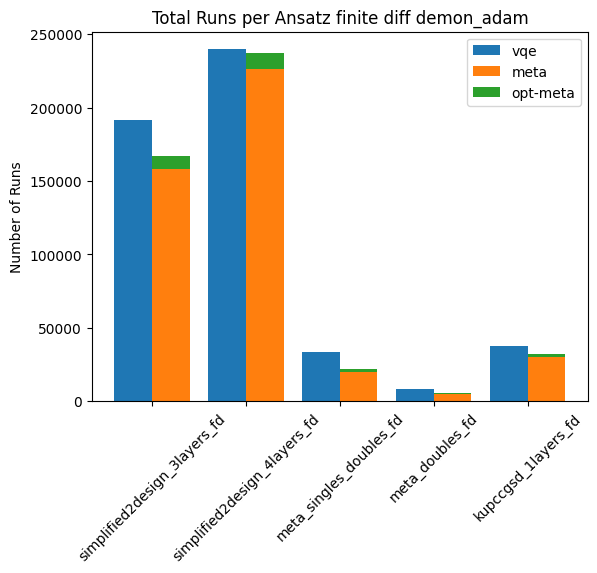

In [11]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]


print(meta_runs)


ind = np.arange(len(vqe_data)) 

width = 0.4                      # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz finite diff {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(width/2))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")
ax.legend()
plt.show()